In [1]:
import numpy as np
import os
from PIL import Image, ImageChops
import matplotlib.pyplot as plt

# Prepare classes mapping

In [2]:
#mapping
TRAIN_DIR = 'C:\mgr_detekcja\data_50'
LABELS_DIR = [ x for x in os.listdir(TRAIN_DIR) ]
LABELS  = [n+1 for n in range(len(LABELS_DIR))]

labels_to_num_dict = dict(zip(LABELS_DIR, LABELS))
num_to_labels_dict = dict(zip(LABELS, LABELS_DIR))

In [3]:
def define_aug(aug, image):
    return aug(image=image)['image']

# Define images transformation and methods for prepare data

In [4]:
import random
import glob
from albumentations import (
RandomScale,
RandomRotate90    
)

def generate_patterns_dict(path_patterns_list):
    patterns_dict = dict()   
    for path_to_pattern in path_patterns_list:
        category = os.path.split(path_to_pattern)[1] 
        patterns_dict[category] = []      
        files_paths = glob.glob(path_to_pattern+'\*')
        
        for i, path_to_one_file in enumerate(files_paths):
            open_img = Image.open(path_to_one_file).convert('RGB')
            patterns_dict[category].append(open_img)
            
    return patterns_dict

def generate_canvas_image(patterns_dict, canvas_size, max_image_size, fill):
    black = (0,0,0)
    canvas = Image.new('RGB', (canvas_size), black)
    canvas_w, canvas_h = canvas.size
    grid = int(canvas_size[0]/max_image_size[0])
    bboxes = []
    category = []
    for i in range(grid):
        for j in range(grid):
            value = random.randint(1,10)
            if (value % fill) == 0:
                continue
                         
            messier_category, files_for_pattern = random.choice(list(patterns_dict.items()))
            messier_img = random.choice(files_for_pattern)
            scale = RandomScale(scale_limit=(-0.7,0.4), interpolation=1, always_apply=False, p=0.75)
            rotate = RandomRotate90(p=0.75)

            messier_img = Image.fromarray(define_aug(scale,np.array(messier_img)))
            messier_img = Image.fromarray(define_aug(rotate,np.array(messier_img)))
            messier_img.thumbnail((max_image_size))

            canvas.paste(messier_img, (i*max_image_size[0],j*max_image_size[0]))
            #coco notation
            w, h = messier_img.size
            bboxes.append([i*max_image_size[0],j*max_image_size[0],w, h]) 
            category.append(messier_category)   
                         
    return canvas, bboxes, category

# Load data from prepared directories ( from first notebook)

In [5]:
data_50_list = glob.glob('C:\mgr_detekcja\data_50\*')
patterns_dict = generate_patterns_dict(data_50_list)

# Define size of element, way of fill image and number of samples in dataset

In [6]:
from tqdm import tqdm
canvas_numpy_training_list = []
max_image_size = (500,500)
canvas_size = (1500,1500)

for i in tqdm(range(1000)):
    canvas, bboxes, category = generate_canvas_image(patterns_dict, canvas_size, max_image_size, fill = 3)  
    canvas_numpy = np.array(canvas)
    annotations = {'image': canvas_numpy, 'bboxes': bboxes, 'category': category}
    canvas_numpy_training_list.append(annotations)  

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.30it/s]


# Write elements coded in coco format to .csv file

In [9]:
from tqdm import tqdm
data_set_path = 'PATH_TO_SAVE_FILES'
import pandas as pd 

data_frame_set = pd.DataFrame()
        
for counter, elem in enumerate(tqdm(canvas_numpy_training_list)):     
    img = Image.fromarray(elem['image'])
    img.save(os.path.join(data_set_path,str(counter)+'.jpg'))
    bboxes = elem['bboxes']
    categories = elem['category']
    img_width, img_height = img.size
    img_name = str(counter)+'.jpg'
    
    for bbox, category in zip(bboxes, categories):
        data_frame = data_frame.append({'img_file': img_name, 
                'img_width': img_width, 'img_height': img_height, 'category': category, 'xmin': bbox[0], 
                'xmax': bbox[0]+bbox[2], 'ymin': bbox[1], 'ymax': bbox[1]+bbox[3]}, ignore_index=True)    
    

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.20it/s]


"\nfor counter, elem in enumerate(tqdm(canvas_numpy_training_list)):     \n    img = Image.fromarray(elem['image'])\n    img.save(os.path.join(data_set_path,str(counter)+'.jpg'))\n"

In [11]:
data_frame_set[['img_height', 'img_width', 'xmax', 'xmin', 'ymax', 'ymin']] =  data_frame_set[['img_height', 'img_width', 'xmax', 'xmin', 'ymax', 'ymin']].astype(int)
data_frame_set.to_csv(os.path.join(data_set_path,'set_50.csv'))

In [10]:
data_frame['category'].nunique()

50

# Elements of dataset visualization

In [12]:
import cv2
RECTANGLE_COLOR = (255, 255, 255)
#BOX_COLOR = (255,255,255)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_name, color=RECTANGLE_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), thickness=thickness, color=color)
    #class_name = class_idx_to_name[class_id]  
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_DUPLEX   , 1.5, 0)   
    cv2.putText(img, class_name, (x_min, y_max - int(0.5 * text_height)), cv2.FONT_HERSHEY_DUPLEX   , 1.5,TEXT_COLOR, lineType=cv2.FILLED)
    return img

In [13]:
def visualize(annotations, id_to_name_mapping):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category'][idx])
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

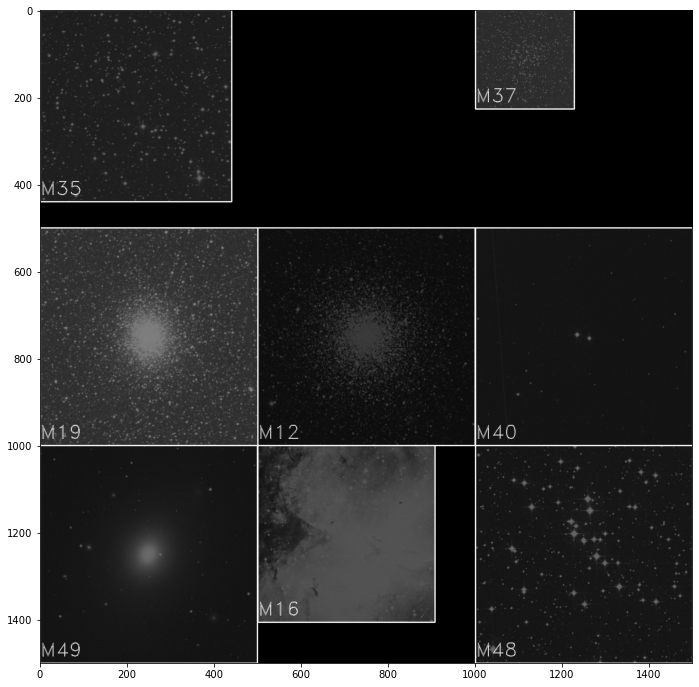

In [18]:
visualize(canvas_numpy_training_list[4], num_to_labels_dict)